In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import max, min, avg, col, count

In [2]:
# Initialisiere Spark-Session
spark = SparkSession.builder.appName("BDA").getOrCreate()
# Zeige die Application ID an
print("Application ID: ", spark.sparkContext.applicationId)

Application ID:  local-1716223338734


In [3]:
def rename_columns(data, colnames):
    for old_name, new_name in zip(data.columns, colnames):
        data = data.withColumnRenamed(old_name, new_name)
    return data

In [4]:
data = spark.read.csv("msd/msd10k_some_metadata.tsv", sep="\t")
new_column_names = ["artist_name", "title", "duration", "loudness", "tempo", "year", "artist_latitude", "artist_longitude", "artist_familiarity", "song_hotttness", "artist_id", "song_id", "track_id"]
data = rename_columns(data, new_column_names)
data.show(10)

+--------------------+--------------------+---------+--------+-------+----+---------------+----------------+-------------------+-------------------+------------------+------------------+------------------+
|         artist_name|               title| duration|loudness|  tempo|year|artist_latitude|artist_longitude| artist_familiarity|     song_hotttness|         artist_id|           song_id|          track_id|
+--------------------+--------------------+---------+--------+-------+----+---------------+----------------+-------------------+-------------------+------------------+------------------+------------------+
|               Alias|       Dying To Stay|310.72608|  -6.192| 111.67|   0|       32.67828|       -83.22295| 0.6453679560153077| 0.4541929882180224|ARHG53Q1187B9ACBFC|SOZASXE12A58A7F12B|TRBDLRT128F4296B2F|
|        George Nooks|     Watchie Watchie|211.66975|  -9.118|168.121|   0|            NaN|             NaN| 0.5637486273655298|                NaN|ARB78VW1187B98F81C|SORAACY12

In [5]:
timbre = spark.read.csv("msd/msd10k_timbre.tsv", sep="\t")
new_column_names = ["title", "track_id", "timbre_0", "timbre_1", "timbre_2", "timbre_3", "timbre_4", "timbre_5", "timbre_6", "timbre_7", "timbre_8", "timbre_9", "timbre_10", "timbre_11"]
# Ändere die Spaltennamen
timbre = rename_columns(timbre, new_column_names)
timbre.show(10)

+-------------+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+
|        title|          track_id|timbre_0|timbre_1|timbre_2|timbre_3|timbre_4|timbre_5|timbre_6|timbre_7|timbre_8|timbre_9|timbre_10|timbre_11|
+-------------+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+
|Dying To Stay|TRBDLRT128F4296B2F|  15.648| -99.562|  25.835| -70.871| 151.718|  51.775|  84.853| -15.358| -13.076| 110.227|    0.101|   23.435|
|Dying To Stay|TRBDLRT128F4296B2F|  19.043|-185.171| -28.193| -48.767| 159.163| -73.907|  75.344|   9.839|  37.073|  13.248|    0.122|    26.19|
|Dying To Stay|TRBDLRT128F4296B2F|  21.604|-173.301|   4.955|  -6.959| 112.465| -73.041|  41.738|    8.23|  23.257|   1.993|   -13.25|  -13.813|
|Dying To Stay|TRBDLRT128F4296B2F|   21.85|-226.187| -44.438| -46.721| 142.245| -73.343|  59.743|   6.978|  29.894|     9.6|   -5.

In [69]:
# Lautstärke
timbre_0 = spark.read.csv("msd/msd10k_timbre0.tsv", sep="\t", header=True)
timbre_0.show(10)
#type(timbre_0['timbre0'])

+------------------+-------+
|          track_id|timbre0|
+------------------+-------+
|TRAAAAW128F429D538|    0.0|
|TRAAAAW128F429D538| 19.991|
|TRAAAAW128F429D538| 20.597|
|TRAAAAW128F429D538| 20.908|
|TRAAAAW128F429D538| 22.173|
|TRAAAAW128F429D538| 32.381|
|TRAAAAW128F429D538| 29.165|
|TRAAAAW128F429D538| 30.153|
|TRAAAAW128F429D538| 31.814|
|TRAAAAW128F429D538| 33.914|
+------------------+-------+
only showing top 10 rows



In [7]:
# Registriere die Daten als temporäre SQL-Tabelle
data.createOrReplaceTempView("msd10k_some_metadata")
timbre.createOrReplaceTempView("msd10k_timbre")
timbre_0.createOrReplaceTempView("msd10k_timbre_0")

+---------+-----+
|duration |count|
+---------+-----+
|216.81587|8    |
|222.14485|8    |
|229.51138|7    |
|181.39383|7    |
|232.202  |7    |
|247.77098|6    |
|220.78649|6    |
|208.79628|6    |
|227.082  |6    |
|174.602  |6    |
+---------+-----+



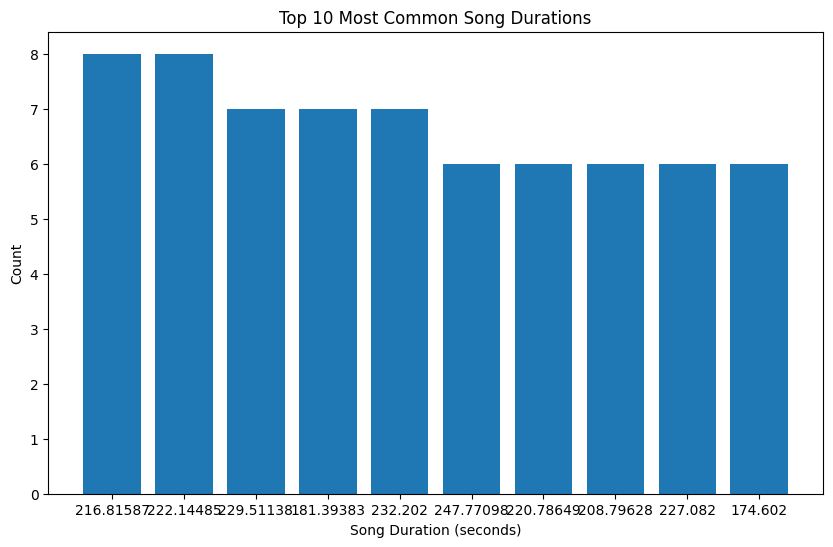

In [8]:
# SQL-Abfrage zum Datenverständnis
query = """
        SELECT duration, COUNT(*) AS count
        FROM msd10k_some_metadata
        GROUP BY duration
        ORDER BY count DESC
        LIMIT 10
        """
        
df = spark.sql(query)
df.show(truncate=False)

# Konvertiere das Ergebnis zu einem Pandas DataFrame
df_pd = df.toPandas()

# Visualisiere die Ergebnisse mit Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(df_pd['duration'], df_pd['count'])
plt.xlabel('Song Duration (seconds)')
plt.ylabel('Count')
plt.title('Top 10 Most Common Song Durations')
plt.show()

+----+-------------------+
|year|avg_loudness       |
+----+-------------------+
|1990|-11.94376388888889 |
|1991|-11.8115054945055  |
|1992|-11.02428571428571 |
|1993|-12.354690476190475|
|1994|-11.604365217391297|
|1995|-10.306577777777779|
|1996|-10.586192660550456|
|1997|-10.465015384615384|
|1998|-10.426311258278144|
|1999|-8.975898876404495 |
+----+-------------------+
only showing top 10 rows



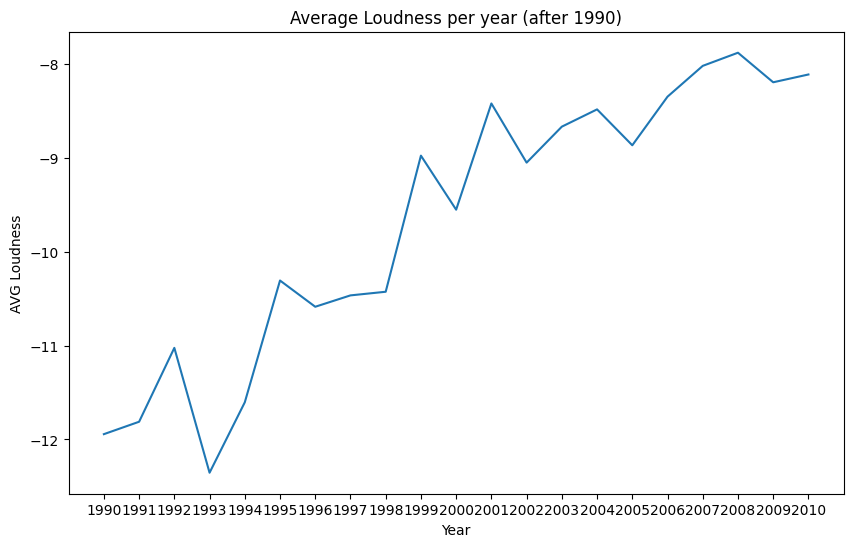

In [9]:
query = """
        SELECT year, AVG(loudness) AS avg_loudness
        FROM msd10k_some_metadata
        WHERE year >= 1990
        GROUP BY year
        ORDER BY year
        """
        
df = spark.sql(query)
df.show(10, truncate=False)

df = df.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['avg_loudness'])
plt.xlabel('Year')
plt.ylabel('AVG Loudness')
plt.title('Average Loudness per year (after 1990)')
#plt.gca().invert_yaxis()
plt.show()

+------------------------------------------+------------+------------+
|artist_name                               |avg_duration|avg_loudness|
+------------------------------------------+------------+------------+
|Ministry of Sound                         |1686.7522   |-7.661      |
|Morton Gould                              |1610.00444  |-32.874     |
|Kartik Seshadri                           |1519.28118  |-23.684     |
|Frederic Galliano                         |1394.75546  |-20.282     |
|The Revolutionary Ensemble                |1253.92934  |-11.973     |
|Small Facers                              |1141.08036  |-18.626     |
|Naseebo Lal_ Arif Lohar                   |1037.68771  |-11.368     |
|Arthur Fiedler;Earl Wild;Pasquale Cardillo|976.56118   |-19.303     |
|Mickey And The Students                   |914.02404   |-7.329      |
|G��teborgs Symfoniker / Neeme J��rvi      |904.80281   |-21.394     |
+------------------------------------------+------------+------------+
only s

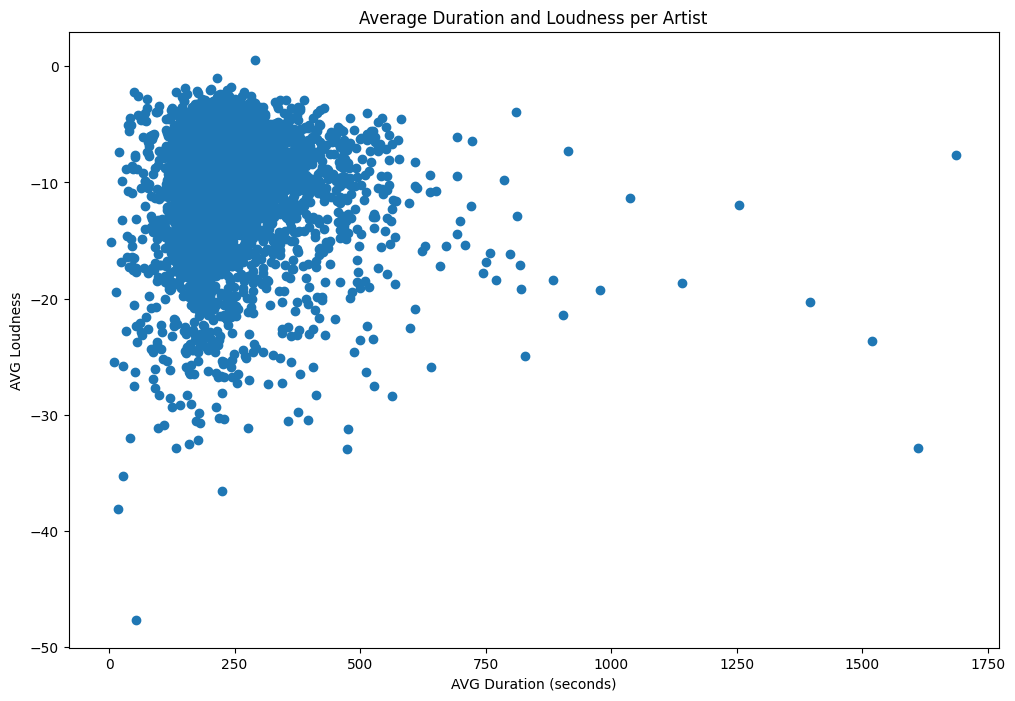

In [10]:
query = """
        SELECT artist_name, AVG(duration) AS avg_duration, AVG(loudness) AS avg_loudness
        FROM msd10k_some_metadata
        GROUP BY artist_name
        ORDER BY avg_duration DESC, avg_loudness DESC
        """
        
df = spark.sql(query)
df.show(10, truncate=False)

df = df.toPandas()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['avg_duration'], df['avg_loudness'])
plt.title('Average Duration and Loudness per Artist')
plt.xlabel('AVG Duration (seconds)')
plt.ylabel('AVG Loudness')
#plt.xscale('log')
#plt.yscale('linear')
plt.show()

In [93]:
query = """
        SELECT track_id, timbre_0
        FROM msd10k_timbre
        """
        
df = spark.sql(query)
df.show(10, truncate=False)

+------------------+--------+
|track_id          |timbre_0|
+------------------+--------+
|TRBDLRT128F4296B2F|15.648  |
|TRBDLRT128F4296B2F|19.043  |
|TRBDLRT128F4296B2F|21.604  |
|TRBDLRT128F4296B2F|21.85   |
|TRBDLRT128F4296B2F|22.861  |
|TRBDLRT128F4296B2F|23.143  |
|TRBDLRT128F4296B2F|25.395  |
|TRBDLRT128F4296B2F|25.261  |
|TRBDLRT128F4296B2F|24.947  |
|TRBDLRT128F4296B2F|26.545  |
+------------------+--------+
only showing top 10 rows



In [100]:
df = df.withColumn("timbre_0", col("timbre_0").cast("float"))
# Berechne die Min- und Max-Werte für die Spalte 'timbre_0'
stats = df.select(
    min("timbre_0").alias("Min_Timbre0"),
    max("timbre_0").alias("Max_Timbre0")
)

# Zeige die berechneten Werte an
stats.show()

# Extrahiere die Min- und Max-Werte als Double
#min_value = float(stats.select(col("Min_Timbre0")).first()[0])
#max_value = float(stats.select(col("Max_Timbre0")).first()[0])

min_value, max_value = stats.collect()[0]

# Bins festlegen
num_bins = 10
bin_width = (max_value - min_value) / num_bins

bins = [min_value + i * bin_width for i in range(num_bins + 1)]


bins = [float(bin) for bin in bins]
#bins = [round(float(bin), 3) for bin in bins]


print(bins)

+-----------+-----------+
|Min_Timbre0|Max_Timbre0|
+-----------+-----------+
|        0.0|      62.68|
+-----------+-----------+

[0.0, 6.2680000305175785, 12.536000061035157, 18.804000091552737, 25.072000122070314, 31.34000015258789, 37.608000183105474, 43.87600021362305, 50.14400024414063, 56.412000274658205, 62.68000030517578]


In [101]:
bucketizer = Bucketizer(splits=bins, inputCol="timbre_0", outputCol="bin")
bucketed = bucketizer.transform(df)
bucketed.show()
bucketed.createOrReplaceTempView("bucketeddata")
#bucketed.write.mode("overwrite").saveAsTable("bucketeddata")

+------------------+--------+---+
|          track_id|timbre_0|bin|
+------------------+--------+---+
|TRBDLRT128F4296B2F|  15.648|2.0|
|TRBDLRT128F4296B2F|  19.043|3.0|
|TRBDLRT128F4296B2F|  21.604|3.0|
|TRBDLRT128F4296B2F|   21.85|3.0|
|TRBDLRT128F4296B2F|  22.861|3.0|
|TRBDLRT128F4296B2F|  23.143|3.0|
|TRBDLRT128F4296B2F|  25.395|4.0|
|TRBDLRT128F4296B2F|  25.261|4.0|
|TRBDLRT128F4296B2F|  24.947|3.0|
|TRBDLRT128F4296B2F|  26.545|4.0|
|TRBDLRT128F4296B2F|  24.994|3.0|
|TRBDLRT128F4296B2F|  23.651|3.0|
|TRBDLRT128F4296B2F|  22.236|3.0|
|TRBDLRT128F4296B2F|  21.863|3.0|
|TRBDLRT128F4296B2F|  21.768|3.0|
|TRBDLRT128F4296B2F|  22.876|3.0|
|TRBDLRT128F4296B2F|  23.127|3.0|
|TRBDLRT128F4296B2F|  25.608|4.0|
|TRBDLRT128F4296B2F|  24.974|3.0|
|TRBDLRT128F4296B2F|  24.983|3.0|
+------------------+--------+---+
only showing top 20 rows



In [102]:
query = """
SELECT 
    xd.track_id,
    COUNT(CASE WHEN xd.bin = 0 THEN 1 END) / t.total AS t0_0,
    COUNT(CASE WHEN xd.bin = 1 THEN 1 END) / t.total AS t0_1,
    COUNT(CASE WHEN xd.bin = 2 THEN 1 END) / t.total AS t0_2,
    COUNT(CASE WHEN xd.bin = 3 THEN 1 END) / t.total AS t0_3,
    COUNT(CASE WHEN xd.bin = 4 THEN 1 END) / t.total AS t0_4,
    COUNT(CASE WHEN xd.bin = 5 THEN 1 END) / t.total AS t0_5,
    COUNT(CASE WHEN xd.bin = 6 THEN 1 END) / t.total AS t0_6,
    COUNT(CASE WHEN xd.bin = 7 THEN 1 END) / t.total AS t0_7,
    COUNT(CASE WHEN xd.bin = 8 THEN 1 END) / t.total AS t0_8,
    COUNT(CASE WHEN xd.bin = 9 THEN 1 END) / t.total AS t0_9
FROM
    bucketeddata xd
JOIN
    (SELECT track_id, COUNT(*) AS total FROM bucketeddata GROUP BY track_id) t
ON xd.track_id = t.track_id
GROUP BY xd.track_id, t.total
ORDER BY xd.track_id
"""
result_df = spark.sql(query)
result_df.show()

+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+----+
|          track_id|                t0_0|                t0_1|                t0_2|                t0_3|                t0_4|                t0_5|               t0_6|                t0_7|                t0_8|t0_9|
+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+----+
|TRAAAAW128F429D538|0.001029866117404...|                 0.0|0.001029866117404...|0.014418125643666324| 0.02368692070030896| 0.10298661174047374| 0.5262615859938208|  0.3305870236869207|                 0.0| 0.0|
|TRAAABD128F429CF47|0.005454545454545455|0.005454545454545455|0.001818181818181...|0.007272727272727273|0.007272727272727273| 0.0636363636363636

In [103]:
result_df.createOrReplaceTempView("profilevectors")
#result_df.write.mode("overwrite").saveAsTable("profilevectors")

In [104]:
query="""
    SELECT 
        track_id, title, AVG(timbre_0) as T0_AVG 
    FROM msd10k_timbre 
    GROUP BY track_id, title 
    ORDER BY T0_AVG DESC
    LIMIT 1
    """
df = spark.sql(query)
df.show(10, truncate=False)

+------------------+-----------+------------------+
|track_id          |title      |T0_AVG            |
+------------------+-----------+------------------+
|TRAIKBM128F429160A|Thresh Hold|55.706055674518204|
+------------------+-----------+------------------+



In [105]:
query="""
    SELECT 
        track_id, title, AVG(timbre_0) as T0_AVG 
    FROM msd10k_timbre 
    GROUP BY track_id, title 
    ORDER BY T0_AVG ASC
    LIMIT 1
    """
df = spark.sql(query)
df.show(10, truncate=False)

+------------------+-----------+-----------------+
|track_id          |title      |T0_AVG           |
+------------------+-----------+-----------------+
|TRAJTCX128F42990AD|Vena Cava 8|4.553611111111111|
+------------------+-----------+-----------------+

